
# **Proyecto Integrador - Avance 2.Ingenieria de caracteristicas**
## **Tecnologico de Monterrey**
------------------------------------------------------------------
### Profa. Dra. Grettel Barceló Alonso

### Prof. Dr. Luis Eduardo Falcón Morales

### Profa. Verónica Sandra Guzmán de Valle
------------------------------------------------------------------
### Marcela Alejandra Rosales Jiménez - A01032022
### José Antonio Mendoza Castro - A01794067



### Instalacion de librerias

In [ ]:
pip install ipython

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [1]:
!pip install -U get-video-properties

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 11.2 MB/s eta 0:00:00


### Carpeta actual

In [2]:
import os

In [3]:
os.getcwd()

'/content'

### Librerias

In [4]:
from google.cloud import storage
from google.colab.patches import cv2_imshow

In [5]:
import pandas as pd
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
import datetime
import random
import re
import json
import io
import pathlib
from base64 import b64encode
from videoprops import get_video_properties

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

### **Recoleccion de datos**

### Cuenta de servicio

In [7]:
credentials = 'project-team-13-8b8c41c85749.json'

In [9]:
client = storage.Client.from_service_account_json(credentials)

### Bucket

In [10]:
bucket_name = 'bucket-video-wts'

In [11]:
bucket = client.get_bucket(bucket_name)

### Lectura de datos

In [12]:
def make_folder(folder_name):
  """
  Funcion que crea una carpeta en el directorio actual.
  """
  folder_path = os.path.join('/content/', folder_name)
  os.makedirs(folder_path, exist_ok=True)

In [13]:
folder_ds = 'dataset'

In [14]:
make_folder(folder_ds)

In [15]:
list_folder = ['dataset/train/', 'dataset/val/', 'dataset/annotations/']

In [16]:
for folder in list_folder:
  make_folder(folder)

In [17]:
list_path = ['train/', 'val/', 'annotations/']

In [18]:
for path in list_path:
  blobs = [blob.name for blob in bucket.list_blobs(prefix=path)]
  df_blobs = pd.DataFrame(blobs, columns=['file'])
  df_blobs['check'] = df_blobs['file'].apply(lambda x: 1 if 'content' in x else 0)
  df_blobs['lenght'] = df_blobs['file'].apply(lambda x: len(x))
  for blob in blobs:
    if len(blob) < 24:
      pass
    else:
      blob_tmp = bucket.blob(blob)
      blob_tmp.download_to_filename('/content/dataset/' + path + blob.split('/')[-1])

### **Funciones**

In [19]:
def get_all_files(files_path):
  """
  Funcion que obtiene una lista de todos los archivos de un directorio.
  """
  files_path = pathlib.Path(files_path)
  listed_elements = list(files_path.rglob("*"))
  listed_files = [e for e in listed_elements if not e.is_dir()]

  return listed_files

In [20]:
def get_listed_files_with_types(listed_files):
  """
  Funcion que obtiene un diccionario con los tipos de archivos y la lista de archivos que pertenecen a ese tipo.
  """
  files_types = {}
  for ff in listed_files:
    ext = ff.suffix
    if not files_types.get(ext):
      files_types[ext] = []
    files_types[ext].append(str(ff))
  return files_types

In [21]:
def get_cap_dataframe(overhead_view_list):
  """
  Funcion que obtiene un dataframe con la informacion de los videos.
  """
  overhead_view_num_frames = {}

  for ff in overhead_view_list:
      cap = cv2.VideoCapture(ff)
      overhead_view_num_frames[ff] = [int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FPS))]

  df_tmp = pd.DataFrame.from_dict(overhead_view_num_frames, orient='index', columns=['num_frames', 'frame_width', 'frame_height', 'fps'])
  df_tmp.reset_index(inplace=True)
  df_tmp.rename(columns={'index': 'video_path'}, inplace=True)

  return df_tmp

In [22]:
def get_radom_file(file_list):
  """
  Funcion que obtiene un archivo aleatorio de un directorio.
  """
  if file_list:
    return random.choice(file_list)
  else:
    return None

In [23]:
def play_video(video_path):

  """
  Funcion que ejecuta un video desde un folder.
  """

  video = open(video_path, 'rb').read()
  video_data_url = 'data:video/mp4;base64,' + b64encode(video).decode()

  print('Video Name: ', video_path)

  return HTML(f"""
  <video width="640" height="480" controls>
    <source src="{video_data_url}" type="video/mp4">
  </video>
  """)

In [24]:
def get_annotation_path(video_path):
  """
  Funcion que obtiene la ruta correspondiente de una anotacion.
  """
  annotation_path = re.search('.*T[0-9](?=_)', video_path).group(0).replace('train', 'annotations') + '_caption.json'
  return annotation_path

In [25]:
def get_annotation(video_path):
  """
  Funcion que obtiene la anotacion correspondiente de un video.
  """
  with open(get_annotation_path(video_path), 'r') as f:
    data = json.load(f)
  return data

In [26]:
def get_video_duration_in_seconds(video_path):
  """
  Funcion que devuelve la duracion en segundos de un video.
  """

  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  durationInSeconds = totalNoFrames // fps

  return 'Duration in seconds: ' +  str(durationInSeconds)

In [53]:
def get_video_characteristics(df_tmp):
  """
  Funcion que obtiene las caracteristicas generales de los videos.
  """

  general_characteristics = {}

  list_seconds = []
  list_width = []
  list_height = []
  list_frames = []
  list_fps = []

  for i, row in df_tmp.iterrows():
    width = row['frame_width']
    height = row['frame_height']
    frame = row['num_frames']
    fps = row['fps']
    durationInSeconds = row['num_frames'] / row['fps']
    list_width.append(width)
    list_height.append(height)
    list_frames.append(frame)
    list_fps.append(fps)
    list_seconds.append(durationInSeconds)

  general_characteristics['width_min'] = min(list_width)
  general_characteristics['width_mean'] = sum(list_width) / len(list_width)
  general_characteristics['width_max'] = max(list_width)
  general_characteristics['height_min'] = min(list_height)
  general_characteristics['height_mean'] = sum(list_height) / len(list_height)
  general_characteristics['height_max'] = max(list_height)
  general_characteristics['frames_min'] = min(list_frames)
  general_characteristics['frames_mean'] = sum(list_frames) / len(list_frames)
  general_characteristics['frames_max'] = max(list_frames)
  general_characteristics['fps_min'] = min(list_fps)
  general_characteristics['fps_mean'] = sum(list_fps) / len(list_fps)
  general_characteristics['fps_max'] = max(list_fps)
  general_characteristics['seconds_min'] = min(list_seconds)
  general_characteristics['seconds_mean'] = sum(list_seconds) / len(list_seconds)
  general_characteristics['seconds_max'] = max(list_seconds)

  return general_characteristics

In [ ]:
def plot_video_characteristics(data):
  """
  Funcion que genera un grafico de barras con las caracteristicas de los videos.
  """
  variables = set([k.split('_')[0] for k in data.keys()])
  fig, axes = plt.subplots(len(variables), 1, figsize=(8, 6 * len(variables)))

  for i, var_name in enumerate(variables):
    ax = axes[i]
    min_val = data.get(f'{var_name}_min', None)
    mean_val = data.get(f'{var_name}_mean', None)
    max_val = data.get(f'{var_name}_max', None)

    if min_val is not None and mean_val is not None and max_val is not None:
      x_labels = ['Min', 'Mean', 'Max']
      values = [min_val, mean_val, max_val]

      ax.bar(x_labels, values, label=var_name)
      ax.set_ylabel('Value')
      ax.set_title(f"Min, Mean and Max of {var_name}")
      ax.legend()
  plt.tight_layout()
  plt.show()

### **Analisis de datos**

In [29]:
dataset_path = f"/content/dataset"

### Cantidad y tipo de archivos a analizar

In [30]:
listed_files = get_all_files(f"{dataset_path}")
print(f"Cantidad de archivos en total = {len(listed_files)}")


files_by_ext = get_listed_files_with_types(listed_files)

for k, v in files_by_ext.items():
    print(f" - Extension {k} tiene {len(v)}")

Cantidad de archivos en total = 1753
 - Extension .json tiene 944
 - Extension .mp4 tiene 809


### Cantidad de videos de entranamiento y validacion

In [31]:
files_overhead_view = []
files_overhead_view_by_type = {
    'train': [],
    'val': [],
}

for mp4 in files_by_ext['.mp4']:
    if not f"{dataset_path}/external" in mp4 and not "vehicle_view" in  mp4:
        files_overhead_view.append(mp4)
        #omitir ruta videos al leer desde colab (videos/train)
        if "train" in mp4:
            files_overhead_view_by_type['train'].append(mp4)
        #omitir ruta videos al leer desde colab (videos/train)
        elif "val" in mp4:
            files_overhead_view_by_type['val'].append(mp4)
        else:
            print(f"W: No train ni val. Que es? {mp4}")


print(f"Cantidad de archivos a utilizar = {len(files_overhead_view)}")
for k, v in files_overhead_view_by_type.items():
    print(f" - {k} tiene {len(v)}")

Cantidad de archivos a utilizar = 600
 - train tiene 403
 - val tiene 197


In [32]:
train_files_overhead_view = [f for f in  files_overhead_view if 'train' in f]

In [33]:
val_files_overhead_view = [f for f in  files_overhead_view if 'val' in f]

### Generacion de un pandas dataframe con las caracteristicas generales de los videos (frames number, width, height, fps)

In [34]:
df_train = get_cap_dataframe(train_files_overhead_view)

In [35]:
df_train.head()

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/train/20231013_114328_normal_...,1937,1920,1080,30
1,/content/dataset/train/20230728_4_CN32_T1_Came...,2296,1920,1080,30
2,/content/dataset/train/20231006_27_SN19_T3_192...,2211,1920,1080,30
3,/content/dataset/train/20231013_114328_normal_...,1898,1920,1080,30
4,/content/dataset/train/20231013_101813_normal_...,2250,1920,1080,29


In [36]:
df_val = get_cap_dataframe(val_files_overhead_view)

In [37]:
df_val.head()

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/val/20230929_13_SN25_T1_192.1...,2139,1920,1080,30
1,/content/dataset/val/20230929_65_SN4_T1_192.16...,2139,1920,1080,30
2,/content/dataset/val/20231013_114328_normal_19...,1888,1920,1080,30
3,/content/dataset/val/20230728_37_CN38_T1_Camer...,2231,1920,1080,30
4,/content/dataset/val/20231013_101845_normal_19...,2029,1920,1080,30


### Anotaciones de los videos de entrenamiento y validacion

In [38]:
annotations = []

for j in files_by_ext['.json']:
    annotations.append(j)

print(f"Cantidad de archivos a utilizar = {len(annotations)}")

Cantidad de archivos a utilizar = 944


### Generacion de un pandas dataframe para la ruta de las anotaciones

In [39]:
df_annot = pd.DataFrame(annotations, columns=['annotation_path'])

In [40]:
df_annot.head()

,annotation_path
0,/content/dataset/annotations/20230929_54_SN38_...
1,/content/dataset/annotations/20230929_59_SN41_...
2,/content/dataset/annotations/20230728_37_CN38_...
3,/content/dataset/annotations/20230922_34_CN11_...
4,/content/dataset/annotations/20230929_20_CY20_...


### Ejecucion de un video aleatorio

In [41]:
video_path = get_radom_file(train_files_overhead_view)

In [ ]:
play_video(video_path)

### Obtencion de la anotacion del video

In [43]:
video_path

'/content/dataset/train/20230707_31_SY20_T1_Camera3_1.mp4'

In [44]:
get_annotation(video_path)

{'vehicle_view': '20230707_31_SY20_T1_vehicle_view.mp4',
 'event_phase': [{'labels': ['4'],
   'caption_pedestrian': "The pedestrian's body faced the opposite direction of the vehicle, and they were positioned directly in front of it, at a close distance. The pedestrian's line of sight was focused on the vehicle, indicating that they were aware of its presence. Their direction of travel was to the right. The pedestrian's action was a collision, which suggests that they were involved in an accident with the vehicle. The pedestrian was moving slowly at the time of the event. As for the environment conditions, the pedestrian was a male in his 20s, with a height of 170 cm. He was wearing a brown jacket on his upper body and gray slacks on his lower body. The weather was clear, but the surroundings were dark. The road surface was dry and level, made of asphalt. The traffic volume was light on this residential road with two-way traffic. There was no sidewalk or roadside strip on both sides, 

In [45]:
get_video_duration_in_seconds(video_path)

'Duration in seconds: 71.0'

In [46]:
props = get_video_properties(video_path)

In [47]:
props

{'index': 0,
 'codec_name': 'h264',
 'codec_long_name': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10',
 'profile': 'High',
 'codec_type': 'video',
 'codec_tag_string': 'avc1',
 'codec_tag': '0x31637661',
 'width': 1920,
 'height': 1080,
 'coded_width': 1920,
 'coded_height': 1080,
 'closed_captions': 0,
 'has_b_frames': 2,
 'sample_aspect_ratio': '1:1',
 'display_aspect_ratio': '16:9',
 'pix_fmt': 'yuvj420p',
 'level': 40,
 'color_range': 'pc',
 'chroma_location': 'left',
 'refs': 1,
 'is_avc': 'true',
 'nal_length_size': '4',
 'r_frame_rate': '30/1',
 'avg_frame_rate': '30/1',
 'time_base': '1/15360',
 'start_pts': 0,
 'start_time': '0.000000',
 'duration_ts': 1092608,
 'duration': '71.133333',
 'bit_rate': '9369165',
 'bits_per_raw_sample': '8',
 'nb_frames': '2134',
 'disposition': {'default': 1,
  'dub': 0,
  'original': 0,
  'comment': 0,
  'lyrics': 0,
  'karaoke': 0,
  'forced': 0,
  'hearing_impaired': 0,
  'visual_impaired': 0,
  'clean_effects': 0,
  'attached_pic': 0,
  'timed

### Estadisticas para los datos de entrenamiento

In [48]:
df_train.head(3)

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/train/20231013_114328_normal_...,1937,1920,1080,30
1,/content/dataset/train/20230728_4_CN32_T1_Came...,2296,1920,1080,30
2,/content/dataset/train/20231006_27_SN19_T3_192...,2211,1920,1080,30


In [54]:
get_video_characteristics(df_train)

{'width_min': 1920,
 'width_mean': 1920.0,
 'width_max': 1920,
 'height_min': 1080,
 'height_mean': 1080.0,
 'height_max': 1080,
 'frames_min': 1861,
 'frames_mean': 2239.2952853598017,
 'frames_max': 7735,
 'fps_min': 29,
 'fps_mean': 29.98759305210918,
 'fps_max': 30,
 'seconds_min': 62.03333333333333,
 'seconds_mean': 74.67660363366703,
 'seconds_max': 257.8333333333333}

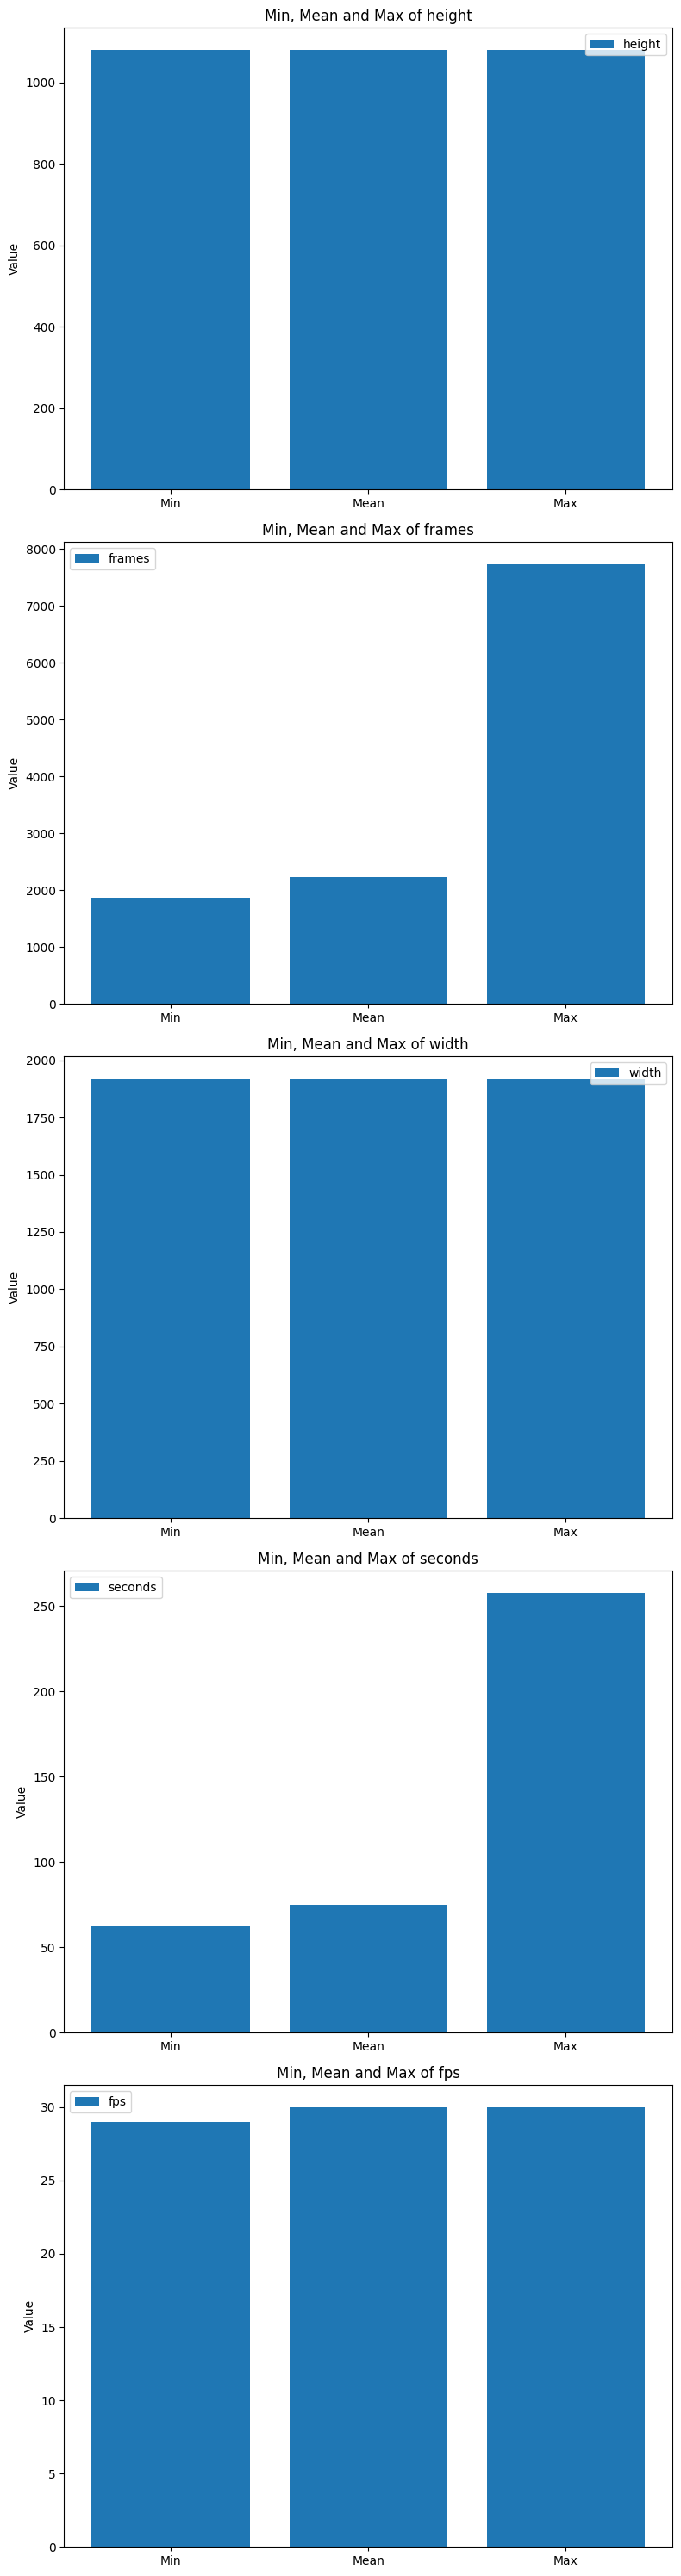

In [56]:
plot_video_characteristics(get_video_characteristics(df_train))

### Estadisticas para los datos de validacion

In [57]:
df_val.head(3)

,video_path,num_frames,frame_width,frame_height,fps
0,/content/dataset/val/20230929_13_SN25_T1_192.1...,2139,1920,1080,30
1,/content/dataset/val/20230929_65_SN4_T1_192.16...,2139,1920,1080,30
2,/content/dataset/val/20231013_114328_normal_19...,1888,1920,1080,30


In [58]:
get_video_characteristics(df_val)

{'width_min': 1920,
 'width_mean': 1923.4111675126903,
 'width_max': 2592,
 'height_min': 1080,
 'height_mean': 1084.3857868020305,
 'height_max': 1944,
 'frames_min': 1873,
 'frames_mean': 2165.1522842639592,
 'frames_max': 2493,
 'fps_min': 30,
 'fps_mean': 30.0,
 'fps_max': 30,
 'seconds_min': 62.43333333333333,
 'seconds_mean': 72.17174280879857,
 'seconds_max': 83.1}

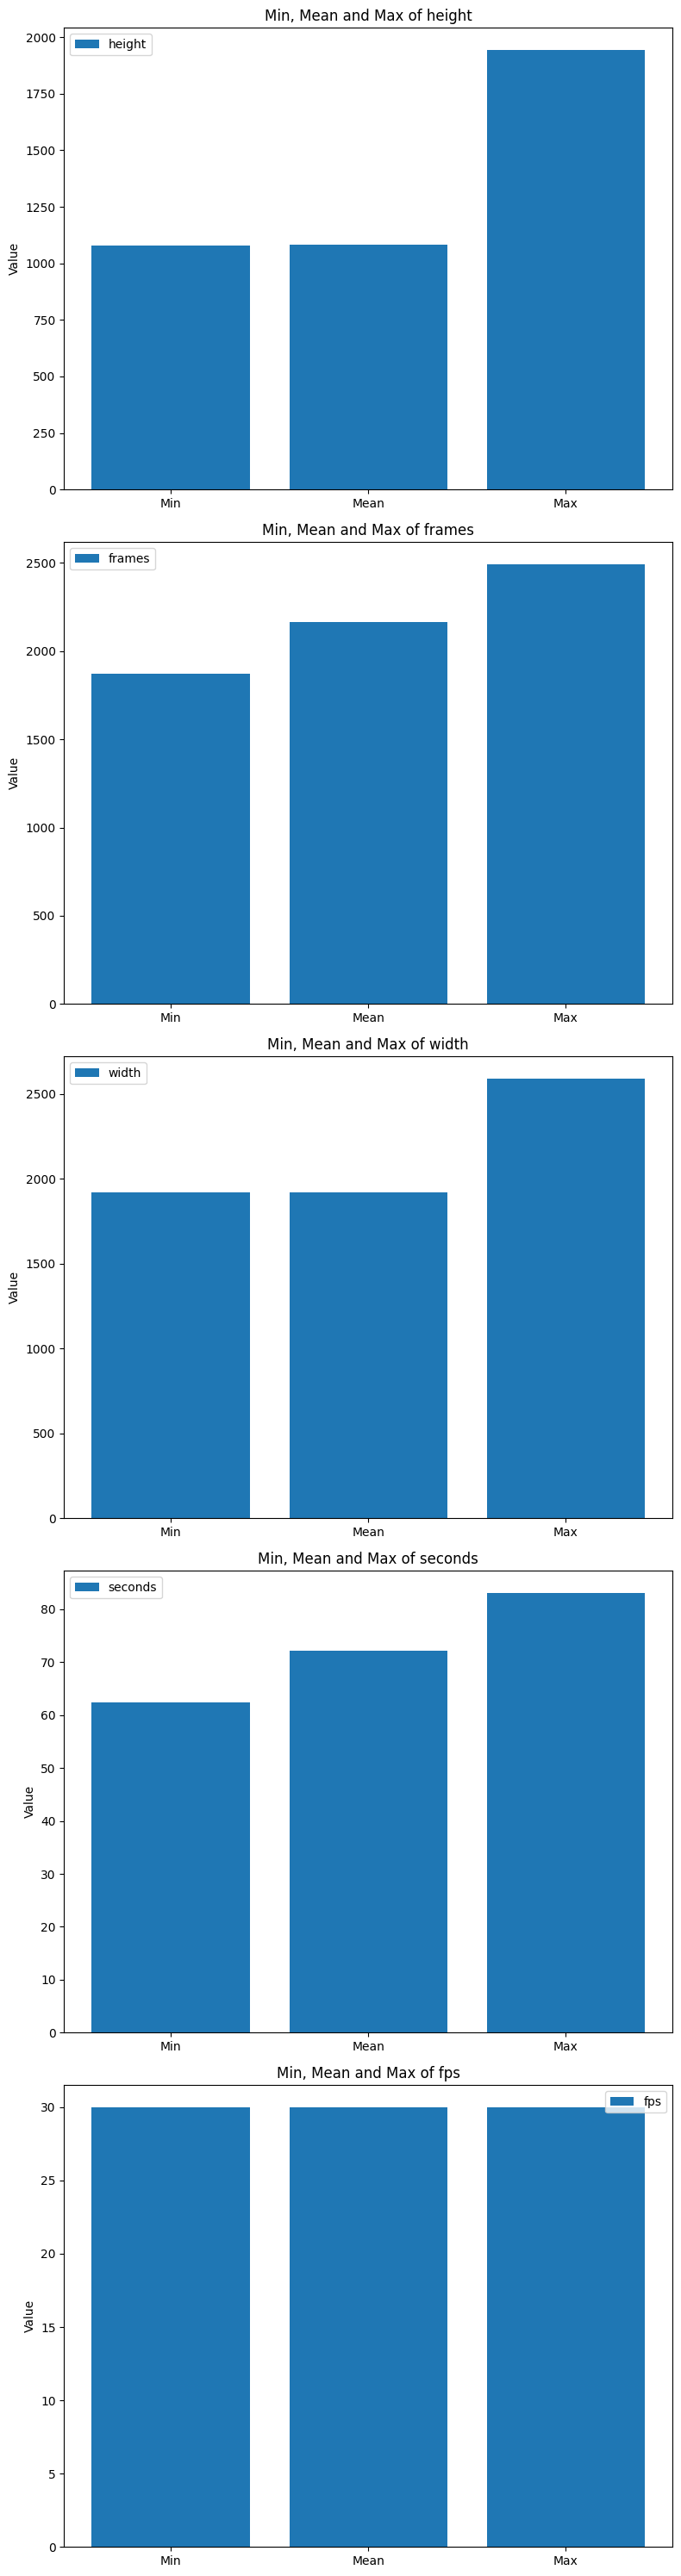

In [59]:
plot_video_characteristics(get_video_characteristics(df_val))

### **Ingenieria de caracteristicas**

Para esta seccion consideramos dos pasos importantes para el tratamiento de las anotaciones de los videos:



*   Preprocesamiento del texto
*   Extraccion de caracteristicas

Para el primero consideramos normalizar el texto, conviertiendo todas las palabras a minusculas, eliminando las palabras mas comunes que no aportan un significado relevante al mismo y obteniendo las raices de las palabras a partir de la lemantizacion. Esto lo realizamos para mejorar nuestro insumo.

Para la extraccion de caracteristicas utilizamos Term Frequency-Inverse Document Frequency (TF-IDF) para convertir las parablas a vectores y poder ocupar en una clusterizacion.



In [60]:
def get_preprocessing_of_annotation(text):
  """
  Funcion que obtiene el preprocesamiento de una anotacion.
  """
  #Minusculas
  text = text.lower()

  #Remover puntuacion
  text = re.sub(r'[^\w\s]', '', text)

  #Remover stop words
  stop_words = set(stopwords.words('english'))
  text = ' '.join([word for word in text.split() if word not in stop_words])

  #Lemantizacion
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [61]:
def write_annotation_preprocess(df_tmp):
  """
  Funcion que obtiene la anotacion preprocesada.
  """
  for i, row in df_tmp.iterrows():

    if 'caption' in row['annotation_path']:

      with open(row['annotation_path'], 'r') as input_file:
        data_tmp = json.load(input_file)

      for i, j in enumerate(data_tmp['event_phase']):
        data_tmp['event_phase'][i]['caption_pedestrian'] = get_preprocessing_of_annotation(data_tmp['event_phase'][i]['caption_pedestrian'])
        data_tmp['event_phase'][i]['caption_vehicle'] = get_preprocessing_of_annotation(data_tmp['event_phase'][i]['caption_vehicle'])

        with open(row['annotation_path'].replace('annotations', 'annotations_preprocess'), 'w') as output_file:
          json.dump(data_tmp, output_file)
    else:
      pass

In [62]:
def feature_engineering(annotation_tmp):
  """
  Funcion que realiza la ingenieria de caracteristicas.
  """
  vectorizer = TfidfVectorizer(max_features=5000)

  vectorizer.fit(annotation_tmp)

  feature_matrix = vectorizer.transform(annotation_tmp)

  return feature_matrix

In [63]:
def clustering(feature_matrix, num_clusters=5):
  """
  Funcion que realiza el clustering.
  """
  kmeans = KMeans(n_clusters=num_clusters, random_state=0)

  kmeans.fit(feature_matrix)

  cluster_assigments = kmeans.labels_

  return cluster_assigments

In [64]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Se crea un nuevo folder para los datos pre-procesados

In [65]:
make_folder('dataset/annotations_preprocess')

### Se aplica el preprocesamiento y se escriben los archivos en el nuevo folder

In [66]:
write_annotation_preprocess(df_annot)

### Archivo sin procesamiento

In [67]:
get_annotation('dataset/annotations/20230707_12_SN17_T1_caption.json')

{'vehicle_view': '20230707_12_SN17_T1_vehicle_view.mp4',
 'event_phase': [{'labels': ['4'],
   'caption_pedestrian': 'The pedestrian, a male in his 30s approximately 170 cm tall, was wearing a black T-shirt and black slacks. It was a clear and bright day with dry road conditions on a residential road with two-way traffic. There were no sidewalks on both sides, and street lights were present. The pedestrian was positioned directly in front of a vehicle, facing the opposite direction. The pedestrian noticed the vehicle and was slowly moving in front of it. Suddenly, a collision occurred.',
   'caption_vehicle': 'The vehicle is positioned in front of a pedestrian, close in proximity. The vehicle has a clear field of view, as the pedestrian is visible. The vehicle is currently stopped and its speed is 0 km/h. The gender of the pedestrian is male, in his 30s with a height of 170 cm. He is wearing a black T-shirt on the upper body and black slacks on the lower body. The weather is clear and 

### Archivo con procesamiento

In [68]:
get_annotation('dataset/annotations_preprocess/20230707_12_SN17_T1_caption.json')

{'vehicle_view': '20230707_12_SN17_T1_vehicle_view.mp4',
 'event_phase': [{'labels': ['4'],
   'caption_pedestrian': 'pedestrian male 30 approximately 170 cm tall wearing black tshirt black slack clear bright day dry road condition residential road twoway traffic sidewalk side street light present pedestrian positioned directly front vehicle facing opposite direction pedestrian noticed vehicle slowly moving front suddenly collision occurred',
   'caption_vehicle': 'vehicle positioned front pedestrian close proximity vehicle clear field view pedestrian visible vehicle currently stopped speed 0 kmh gender pedestrian male 30 height 170 cm wearing black tshirt upper body black slack lower body weather clear brightness bright road surface condition dry road level asphalt traffic volume usual twoway residential road sidewalk side roadside strip street light present',
   'start_time': '9.476',
   'end_time': '14.017'},
  {'labels': ['3'],
   'caption_pedestrian': 'pedestrian male 30 stood per

In [69]:
folder_preprocess_path = 'dataset/annotations_preprocess/'

In [70]:
preprocessed_data = []

In [71]:
for filename in os.listdir(folder_preprocess_path):
  if filename.endswith('.json'):
    filepath = os.path.join(folder_preprocess_path, filename)
    with open(filepath, 'r') as f:
      data = json.load(f)
      for item in data['event_phase']:
        preprocessed_data.append(item['caption_pedestrian'])

In [72]:
feature_matrix = feature_engineering(preprocessed_data)

In [73]:
cluster_assigments = clustering(feature_matrix)

In [74]:
print(cluster_assigments)

[0 4 0 ... 4 4 4]


### Conclusiones

Para esta entrega realizamos la ingenieria de caracteristicas en la cual normalizamos el texto y aplicamos una tecnica de extracción de caracteristicas aplicamos los resultados a una primera prueba aplicando un algoritmo de clusterizacion el cual trabajaremos para las futuras entragas.